In [267]:
# Alteração do diretório para o diretório acima (gasification)
import os
import sys
import path_file
os.chdir(os.path.dirname(os.path.dirname(path_file.__file__)))
os.getcwd()

'd:\\user\\Desktop\\Faculdade\\IC Rodolfo\\gasification 08-2023\\gasification'

In [268]:
# Importação de bibliotecas essenciais
import cantera as ct
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.legend_handler import HandlerTuple

# Importação dos módulos
import phases
import energy as en
import fuel as fu
import gasifier as gs
import feedstock as fs

## Base de dados de combustíveis

O arquivo chamado "fuels.csv", que se encontra na pasta "data", trata-se de uma base de dados que contém informações sobre diversos combustíveis (biomassas e combustíveis fósseis) encontrados na literatura (artigos e trabalhos publicados). Cada linha do arquivo corresponde a um combustível diferente, e cada coluna corresponde a um atributo desse combustível.

- ID: é o nome curto de identificação do combustível. É usado para chamá-lo em algumas funções.
- Description: descrição mais comprida do combustível.
- Type: biomassa ou carvão. É usado para determinar uma estimativa das cinzas.
- Category: subtipo da biomassa ou carvão. É usado para determinar uma estimativa das cinzas. Veja o arquivo "ashes.json" para detalhes dos subtipos programados.
- Reference: referência do trabalho utilizado.
- Year: ano de publicação do trabalho.
- DOI: DOI do trabalho.
- Mbasis: base úmida (wb) ou base seca (db) para o valor da umidade.
- Moisture: teor de umidade, em porcentagem, na base especificada em Mbasis.
- Pbasis: base úmida (wb) ou base seca (db) para os valores da análise imediata: FC, VM, Ash.
- FC: teor de carbono fixo (Fixed Carbon), em porcentagem, na base especificada em Pbasis.
- VM: teor de matéria volátil (Volatile Matter), em porcentagem, na base especificada em Pbasis.
- Ash: teor de cinzas (Ashes), em porcentagem, na base especificada em Pbasis.
- HHV: Poder calorífico superior do combustível, em MJ/kg.
- LHV: Poder calorífico inferior do combustível, em MJ/kg.
- Cellulose: teor de celulose (NÃO USADO)
- Hemicellulose: teor de hemicelulose (NÃO USADO)
- Lignin: teor de lignina (NÃO USADO)
- Ubasis: base úmida (wb), base seca (db), ou base seca livre de cinzas (daf) para os valores da análise elementar: C, H, O, N, S, Cl.
- C, H, O, N, S, Cl: teores elementares, em porcentagem, na base especificada em Ubasis.
- SiO2 - Cr2O3: teores de diferentes óxidos presentes nas cinzas. Caso não seja informado, o valor estimado será usado automaticamente.


### Como adicionar novos combustíveis à base de dados?

O script `fuel.py` interage diretamente com a base de dados. Ele possui algumas funções de leitura das informações nela e também permite escrever novos combustíveis nela.

Para adicionar novos combustíveis, basta usar a função chamada `add_to_database`.

As linhas de código a seguir mostram um exemplo de como adicionar um novo combustível.

O código não irá rodar se já houver um combustível com o mesmo ID.

Para deixar um campo em branco, use `None`.

In [269]:
fuelID = 'Tutorial'
Info = {'Description':'Apenas um exemplo', 'Type':'Biomass', 'Category':'Wood', 'Reference':'Anése et al.', 'Year':'2023', 'DOI':'Não existe'}
moist = ['wb', 4.79]
prox = ['wb', 18.23, 72.29, 4.69]
HV = [None, 18.313]
biochem = [None, None, None]
ult = ['wb', 48.88, 6.29, 33.59, 1.7, 0.06, 0.0]
ashC = [None, None, None, None, None, None, None, None, None, None, None]

# Descomente a linha de código abaixo para adicionar.
# fu.add_to_database(fuelID, Info, moist, prox, HV, biochem, ult, ashC)

## O passo-a-passo da simulação

Todos os algoritmos presentes nesse pacote são baseados neste objeto da biblioteca Cantera, chamado de `Mixture`. Ele representa uma mistura de duas ou mais fases, com composição e propriedades termodinâmicas bem determinadas. No caso da gaseificação, as fases serão as fases sólida e gasosa.

No arquivo `phases.py`, além de algumas funções básicas, também há a definição de uma nova classe de objetos chamada `Stream`, que é praticamente igual à `Mixture`. A classe Stream foi criada herdando todas as funcionalidades (métodos e atributos) da classe `Mixture` original, e adicionando mais algunas interessantes para a gaseificação.

Os atributos são valores ou propriedades de um objeto, e os métodos são funções que podem ser aplicadas a esse objeto.

Para fazer a simulação da gaseificação, é preciso:
1. Criar uma instância do objeto `Stream` que represente o combustível;
2. Criar uma instância do objeto `Stream` que represente o agente gaseificador;
3. Realizar a simulação com esses dois objetos;
4. Extrair e visualizar os dados de saída.

Vamos realizar cada etapa em detalhes.

### 1. Criando a corrente de combustível

O arquivo `feedstock.py` é o principal arquivo a ser usado para criação de correntes.

A corrente de combustível pode ser criada de duas formas:

(a) Usando informações de um combustível presente na base de dados;

(b) Fornecendo todas as informações diretamente, sem passar pela base de dados.

Na opção (a), usa-se a função chamada `create_fuel_from_db` do arquivo `feedstock.py`, informando o ID, a massa seca e a umidade em base seca.

In [270]:
fuel1 = fs.create_fuel_from_db('Pine2', 1, 7.1)

Na opção (b), usa-se a função chamada `create_fuel_stream` do arquivo `feedstock.py`, informando todas as informações requisitadas, _em base seca_.

In [271]:
ultimate = [45.2, 5.4, 39.0, 0.1, 0, 0] # Análise elementar
ash_WB = 0.9/100 # Fração de cinzas, base úmida
moist_WB = 9.4/100 # Umidade, base úmida
LHV_WB = 16.4 # Poder calorífico inferior, base úmida, MJ/kg

ash = ash_WB / (1 - moist_WB) # Convertendo cinzas para base seca
moist = moist_WB / (1 - moist_WB) # Convertendo umidade para base seca
LHV = LHV_WB / (1 - moist_WB) # Convertendo PCI para base seca

fuel2 = fs.create_fuel_stream(1, ultimate, ash, moist, LHV=LHV) # Criando a corrente

# A próxima linha usa um método específico das Streams para 
# estimar o HHV (Poder calorífico superior) usando o LHV, e armazena isso como um atributo do objeto.
fuel2.set_HHV_from_LHV(LHV)

### 2. Criando a corrente de agente gaseificador

O agente gaseificador pode ser ar, oxigênio puro ou vapor d'água. Atualmente, o código não suporta mistura desses agentes.

É possível criar uma corrente de agente gaseificador especificando sua massa, com as funções de `feedstock.py`:
- `create_air_stream`
- `create_O2_stream`
- `create_steam_stream`

Mais comumente, é informada a razão de equivalência (ER), nos casos de ar ou oxigênio. Assim, podem ser usadas as funções:
- `create_air_from_ER`
- `create_O2_from_ER`

Ou, no caso do vapor, a razão vapor-carbono (SCR):
- `create_steam_from_SCR`

Vamos testar criando uma corrente de ar com ER = 0.3:

In [272]:
ER = 0.3
air1 = fs.create_air_from_ER(fuel2, ER)

### 3. Simulando a gaseificação

Há duas formas de simular a gaseificação: isotérmica ou não-isotérmica.

A simulação isotérmica é usada quando a temperatura de equilíbrio já é especificada. Nesse caso, o código não faz cálculos de balanço de energia.
A simulação não-isotérmica é usada quando a temperatura de equilíbrio não é especificada e precisa ser determinada pelo balanço de energia.

Os resultados da simulação são armazenados em um objeto da classe `Stream`, que chamarei de `outlet`. 

Veja a simulação da gaseificação isotérmica:

In [273]:
outlet1 = gs.gasify_isot(fuel2, air1, T=800)

E a simulação da gaseificação não-isotérmica:

In [274]:
outlet2 = gs.gasify_nonisot(fuel2, air1)

### 4. Extraindo os resultados

É claro que precisamos verificar os resultados de nossa simulação. Para isso, iremos usar os métodos da classe `Stream` que são apresentados no arquivo `phases.py`.
- `get_syngas_fraction`: retorna a fração molar da espécie especificada na fase gasosa. Pode-se optar por retirar a água e o nitrogênio dos cálculos.

In [275]:
print('A porcentagem de H2 no primeiro caso é', 100*outlet1.get_syngas_fraction('H2', water=True, nitrogen=True), '%')
print('A porcentagem de H2 no segundo caso é', 100*outlet2.get_syngas_fraction('H2', water=True, nitrogen=True), '%')

A porcentagem de H2 no primeiro caso é 14.067519116969663 %
A porcentagem de H2 no segundo caso é 21.861983342064146 %


- `get_syngas_hhv`: retorna o Poder Calorífico Superior do syngas, nas unidades especificadas. Pode-se optar por retirar a água e o nitrogênio dos cálculos.

In [276]:
print('O PCS no primeiro caso é', outlet1.get_syngas_hhv(basis='vol', water=False, nitrogen=True), 'MJ/Nm³')
print('O PCS no segundo caso é', outlet2.get_syngas_hhv(basis='vol', water=False, nitrogen=True), 'MJ/Nm³')

O PCS no primeiro caso é 3.9524613489234772 MJ/Nm³
O PCS no segundo caso é 6.210539504148558 MJ/Nm³


- `get_syngas_amount`: retorna a quantidade de syngas, em volume, massa ou mol. Pode-se optar por retirar a água e o nitrogênio dos cálculos. Útil para determinação do rendimento, que é Nm³ de syngas dividido pela massa inicial de combustível.

In [277]:
fuelmass = fuel2.get_mass()
vol1 = outlet1.get_syngas_amount(basis='vol', water=True, nitrogen=True)
vol2 = outlet2.get_syngas_amount(basis='vol', water=True, nitrogen=True)

print('O rendimento no primeiro caso é', vol1/fuelmass, 'Nm³/kg')
print('O rendimento no segundo caso é', vol2/fuelmass, 'Nm³/kg')

O rendimento no primeiro caso é 2.130012324433718 Nm³/kg
O rendimento no segundo caso é 2.475808523781775 Nm³/kg


- `get_syngas_cge`: retorna a Eficiência de Gás Frio (CGE) do syngas, que é uma medida do aproveitamento energético da gaseificação.

In [278]:
print('A CGE no primeiro caso é', 100*outlet1.get_syngas_CGE(), '%')
print('A CGE no segundo caso é', 100*outlet2.get_syngas_CGE(), '%')

A CGE no primeiro caso é 40.93463081088889 %
A CGE no segundo caso é 82.42452485497803 %


Também é possível usar arrays do `numpy` e laços de repetição `for` para executar várias simulações em diferentes condições, e assim construir gráficos, como no exemplo abaixo.

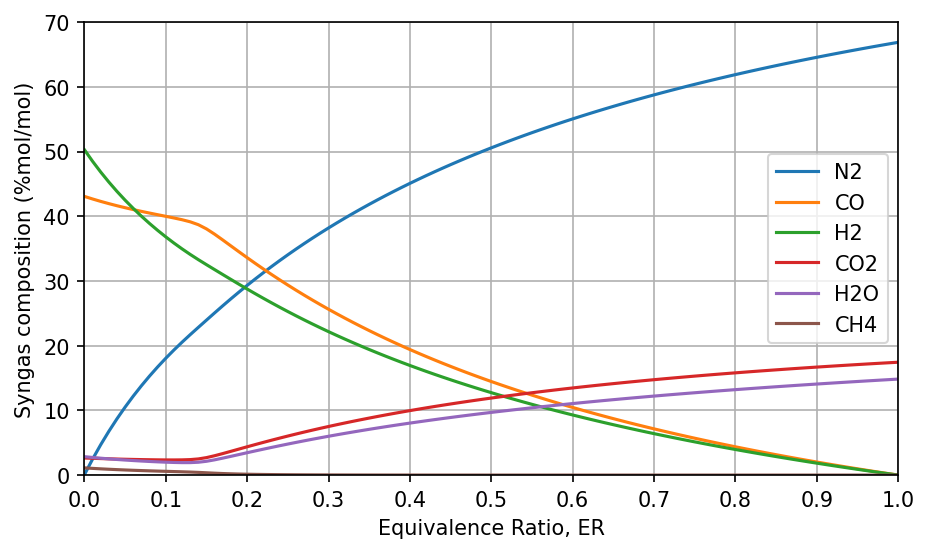

In [279]:
T = 800 + 273.15 # K
P = 1E5 # Pa
ERs = np.arange(0.0, 1.0+1E-6, 0.01)
OUT1 = []

for j, er in enumerate(ERs):
    air = fs.create_air_from_ER(fuel2, er)
    outlet1 = gs.gasify_isot(fuel2, air, T, P, charFormation=0, directMethaneConv=0)
    OUT1.append(outlet1)

species = ['N2', 'CO', 'H2', 'CO2', 'H2O', 'CH4']
y1 = np.zeros((len(species), len(OUT1)))

for i, sp in enumerate(species):
    composition = [out.get_syngas_fraction(sp, water=True, nitrogen=True) for out in OUT1]
    y1[i] = composition

fig0 = plt.figure(figsize=(7,4), dpi=150)
for i, sp in enumerate(species):
    plt.plot(ERs, 100*y1[i], label=sp)
plt.xlim(0, 1)
plt.ylim(0, 70)
plt.xticks(np.arange(ERs[0], ERs[-1]+1E-6, 0.1))
plt.legend()
plt.xlabel('Equivalence Ratio, ER')
plt.ylabel('Syngas composition (%mol/mol)')
plt.grid()
plt.show()

### Modificações do modelo

Na atual implementação, o código suporta as seguintes modificações:
- Estimativa da formação de char: o algortimo reserva uma fração do carbono alimentado para não ser alimentada ao modelo de equilíbrio, permanecendo na forma de carbono sólido (char).
- Estimativa da formação de metano: o algoritmo reserva uma fração do carbono alimentado para ser convertida diretamente em CH4, sem passar pelo modelo de equilíbrio.

Para alterar a formação de char:

In [280]:
outlet3 = gs.gasify_isot(fuel2, air1, T=800, charFormation=0.15)

print('A porcentagem de H2 é', 100*outlet3.get_syngas_fraction('H2', water=True, nitrogen=True), '%')
print('O PCS é', outlet3.get_syngas_hhv(basis='vol', water=False, nitrogen=True), 'MJ/Nm³')
vol3 = outlet3.get_syngas_amount(basis='vol', water=True, nitrogen=True)
print('O rendimento é', vol3/fuelmass, 'Nm³/kg')
print('A CGE é', 100*outlet3.get_syngas_CGE(), '%')

A porcentagem de H2 é 14.065285161581153 %
O PCS é 3.9423249415632333 MJ/Nm³
O rendimento é 2.129783588138822 Nm³/kg
A CGE é 40.803204508976194 %


Para alterar a formação de metano:

In [281]:
outlet4 = gs.gasify_isot(fuel2, air1, T=800, directMethaneConv=0.15)

print('A porcentagem de H2 é', 100*outlet4.get_syngas_fraction('H2', water=True, nitrogen=True), '%')
print('A porcentagem de CH4 é', 100*outlet4.get_syngas_fraction('CH4', water=True, nitrogen=True), '%')
print('O PCS é', outlet4.get_syngas_hhv(basis='vol', water=False, nitrogen=True), 'MJ/Nm³')
vol4 = outlet4.get_syngas_amount(basis='vol', water=True, nitrogen=True)
print('O rendimento é', vol4/fuelmass, 'Nm³/kg')
print('A CGE é', 100*outlet4.get_syngas_CGE(), '%')

A porcentagem de H2 é 9.352328170335985 %
A porcentagem de CH4 é 7.3180029236417115 %
O PCS é 5.212242873755848 MJ/Nm³
O rendimento é 2.077538342489173 Nm³/kg
A CGE é 54.98603490318992 %


No caso não-isotérmico, também é possível especificar um termo de percentagem de calor perdida ao ambiente. Esta percentagem será multiplicada pelo PCS do combustível.

In [282]:
outlet5 = gs.gasify_nonisot(fuel2, air1, heatLossFraction=0.25)

print('A porcentagem de H2 é', 100*outlet5.get_syngas_fraction('H2', water=True, nitrogen=True), '%')
print('A porcentagem de CH4 é', 100*outlet5.get_syngas_fraction('CH4', water=True, nitrogen=True), '%')
print('O PCS é', outlet5.get_syngas_hhv(basis='vol', water=False, nitrogen=True), 'MJ/Nm³')
vol5 = outlet5.get_syngas_amount(basis='vol', water=True, nitrogen=True)
print('O rendimento é', vol5/fuelmass, 'Nm³/kg')
print('A CGE é', 100*outlet5.get_syngas_CGE(), '%')

A porcentagem de H2 é 2.214509012549807 %
A porcentagem de CH4 é 4.618086576849496 %
O PCS é 2.8407770498145006 MJ/Nm³
O rendimento é 1.9558633360165651 Nm³/kg
A CGE é 23.594486051354213 %
